In [1]:
import os
import glob
import numpy as np
import awkward

In [2]:
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt

In [3]:
# import matplotlib
# %matplotlib inline
# import matplotlib.pyplot as plt

In [4]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [5]:
# taken from the training outputs -- update if needed
#presel_eff = {0: 0.0531643892564612, 1: 0.9818927295320153, 10: 0.9940605634291205, 100: 0.9957324620030694, 1000: 0.9973451587037725}
# Latest:
presel_eff = {1: 0.9462915132531003, 10: 0.9870015349946112, 100: 0.9933834048640916, 1000: 0.997, 0: 0.025127295226218364}

In [6]:
#sig_filelist = glob.glob('/home/pmasterson/ParticleNet/LDMX-scripts/GraphNet/plot_data/v12_background_12M/*map*.parquet')
# looking at double instead of 12M
sig_filelist = ['/home/pmasterson/ParticleNet/LDMX-scripts/GraphNet/plot_data/v12_3region_reduced/output_OUTPUT.parquet']
#bkg_filelist = glob.glob('/home/pmasterson/ParticleNet/LDMX-scripts/GraphNet/plot_data/v12_large_full/*.parquet')
# train on kaon, eval on 300k bkg:  v12_large_full_kaon
# train on ~100k bkg:  plot_data/v12_large_full/ (too small!)
#bkg_filelist = glob.glob('/home/pmasterson/ParticleNet/LDMX-scripts/GraphNet/plot_data/TEST_v12_background_12M/*pn*.parquet')
#bkg_filelist = glob.glob('/home/pmasterson/ParticleNet/LDMX-scripts/GraphNet/plot_data/v12_2region_double/4*.parquet')
bkg_filelist = glob.glob('/home/pmasterson/ParticleNet/LDMX-scripts/GraphNet/plot_data/v12_3region_reduced_eval/*pn*.parquet')



In [25]:
#sig_tables = [awkward.load(f) for f in sig_filelist]
#bkg_tables = [awkward.load(f) for f in bkg_filelist]
sig_tables = [awkward.from_parquet(f) for f in sig_filelist]
bkg_tables = [awkward.from_parquet(f) for f in bkg_filelist]
print("Loaded")
print("sig_tables:")
print(awkward.type(sig_tables[0]))
print("bkg_tables:")
print(awkward.type(bkg_tables[0]))

"""# Plot discValue distr, just to check...
#bins = np.linspace(0.996, 0.998, 100)
bins = np.linspace(0, 1, 100)
plt.figure()
plt.hist(sig_tables[0]['EcalVeto_v12.discValue_'], bins=bins, density=True, histtype='step')
#plt.xlim((0.996,0.998))
#plt.semilogy()
plt.show()
print(sig_tables[0]['EcalVeto_v12.discValue_'])"""

Loaded
sig_tables:
180433 * {"TargetSPRecoilE_pt": ?float32, "EcalVeto_v12.discValue_": float32, "EcalVeto_v12.recoilX_": float32, "EcalVeto_v12.recoilY_": float32, "EcalVeto_v12.summedTightIso_": float32, "ParticleNet_extra_label": int32, "ParticleNet_disc": float32}
bkg_tables:
4039 * {"TargetSPRecoilE_pt": ?float32, "EcalVeto_v12.discValue_": float32, "EcalVeto_v12.recoilX_": float32, "EcalVeto_v12.recoilY_": float32, "EcalVeto_v12.summedTightIso_": float32, "ParticleNet_disc": float32}


"# Plot discValue distr, just to check...\n#bins = np.linspace(0.996, 0.998, 100)\nbins = np.linspace(0, 1, 100)\nplt.figure()\nplt.hist(sig_tables[0]['EcalVeto_v12.discValue_'], bins=bins, density=True, histtype='step')\n#plt.xlim((0.996,0.998))\n#plt.semilogy()\nplt.show()\nprint(sig_tables[0]['EcalVeto_v12.discValue_'])"

In [26]:
load_branches = [
    'EcalVeto_v12.discValue_',
    'EcalVeto_v12.recoilX_',
    'EcalVeto_v12.recoilY_',
    
    'ParticleNet_extra_label',
    'ParticleNet_disc',
    'TargetSPRecoilE_pt', # use this for plotting: this is the recoil electron pT at TargetSP
]

In [27]:
a = {}
for k in load_branches:
    print("Loading "+k)
    arrs = []
    for tab in sig_tables + bkg_tables:
        #print(awkward.type(tab))
        print(tab)
        #print(tab['TargetSPRecoilE_pt'])
        #print(awkward.fields(tab))
        arr = tab[k] if k in awkward.fields(tab) else np.zeros_like(tab['ParticleNet_disc'])
        arrs.append(arr)
    a[k] = awkward.concatenate(arrs)
    if k.startswith('EcalVeto'):
        #a[k] = a[k].regular()
        a[k] = awkward.to_regular(a[k])
        if a[k].ndim==2 and len(a[k][0]) == 1:  #a[k].shape[1]==1:
            a[k] = a[k][:,0]
    #print("   Found {} events".format(len(a[k])))

#t_extra_labels = a['ParticleNet_extra_label']
#print("TESTING")
#print(a['TargetSPRecoilE_pt'][:100])
#print("DONE")
"""p_rec = a['EcalVeto_v12.recoilX_']
#NEW for finding frac of missing-e events
for k in presel_eff:  #Find the fraction of missing-e events for each signal category
    n_events=0
    n_missing_e=0
    for i in range(len(p_rec)):
        if t_extra_labels[i] == k:
            n_events += 1
            #if i<100:  print(p_rec[i])
            if p_rec[i] == -9999:  n_missing_e += 1
    print("Found", n_events, "events for", k, "MeV")
    print("Fraction of events w/ missing electron for "+str(k)+" MeV is ", str(n_missing_e/n_events))"""
print("Done")



Loading EcalVeto_v12.discValue_
[{TargetSPRecoilE_pt: 4.07, ... ParticleNet_disc: 1.35e-16}]
[{TargetSPRecoilE_pt: 5.91, ... ParticleNet_disc: 5.79e-11}]
[{TargetSPRecoilE_pt: 3.01, ... ParticleNet_disc: 2e-18}]
[{TargetSPRecoilE_pt: 2.18, ... ParticleNet_disc: 0.0097}]
[{TargetSPRecoilE_pt: 6.85, ... ParticleNet_disc: 3.12e-11}]
[{TargetSPRecoilE_pt: 1.21, ... ParticleNet_disc: 4.7e-16}]
[{TargetSPRecoilE_pt: 4.92, ... ParticleNet_disc: 1}]
Loading EcalVeto_v12.recoilX_
[{TargetSPRecoilE_pt: 4.07, ... ParticleNet_disc: 1.35e-16}]
[{TargetSPRecoilE_pt: 5.91, ... ParticleNet_disc: 5.79e-11}]
[{TargetSPRecoilE_pt: 3.01, ... ParticleNet_disc: 2e-18}]
[{TargetSPRecoilE_pt: 2.18, ... ParticleNet_disc: 0.0097}]
[{TargetSPRecoilE_pt: 6.85, ... ParticleNet_disc: 3.12e-11}]
[{TargetSPRecoilE_pt: 1.21, ... ParticleNet_disc: 4.7e-16}]
[{TargetSPRecoilE_pt: 4.92, ... ParticleNet_disc: 1}]
Loading EcalVeto_v12.recoilY_
[{TargetSPRecoilE_pt: 4.07, ... ParticleNet_disc: 1.35e-16}]
[{TargetSPRecoilE_p

In [28]:
#NEW:  Remove all hits with/without recoilX_==-999 (or -9999?) (or Y)
"""ntotal = len(a['EcalVeto_v12.recoilX_'])
mask = a['EcalVeto_v12.recoilX_'] != -9999
#print(mask[:50])
for k in load_branches:
    a[k] = a[k][mask]
print("Fraction of events remaining (without missing electron):", len(a[load_branches[0]])/len(mask))"""

#Examine missing electrons in each category:
#NOTE:  uncertain how bkg_tables, etc are structured...
#print(sig_tables[0])

'ntotal = len(a[\'EcalVeto_v12.recoilX_\'])\nmask = a[\'EcalVeto_v12.recoilX_\'] != -9999\n#print(mask[:50])\nfor k in load_branches:\n    a[k] = a[k][mask]\nprint("Fraction of events remaining (without missing electron):", len(a[load_branches[0]])/len(mask))'

In [29]:
for k in a.keys():
    print(k, awkward.type(a[k]))
    #NOTE:  elements of dict are just np arrays
    #So...it should be possible to sift everything accordingly.
    
# Full size:  3395546
# Ehit size:  2789329
# Missing e size:  606217 -> Sizes are all consistent

EcalVeto_v12.discValue_ 204993 * float32
EcalVeto_v12.recoilX_ 204993 * float32
EcalVeto_v12.recoilY_ 204993 * float32
ParticleNet_extra_label 204993 * float64
ParticleNet_disc 204993 * float32
TargetSPRecoilE_pt 204993 * ?float32


In [30]:
def to_categorical(y, num_classes=None):
    """Converts a class vector (integers) to binary class matrix.
    E.g. for use with categorical_crossentropy.
    # Arguments
        y: class vector to be converted into a matrix
            (integers from 0 to num_classes).
        num_classes: total number of classes.
    # Returns
        A binary matrix representation of the input.
    """
    y = np.array(y, dtype='int').ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype='int')
    categorical[np.arange(n), y] = 1
    return categorical


def plotROC(y_preds, y_truth, sample_weight=None, output=None, labels=['signal'], sig_eff=1, bkg_eff=1, energy=0, **kwargs):
    from sklearn.metrics import auc, roc_curve, accuracy_score

    fpr = dict()
    tpr = dict()
    thresholds= dict()
    roc_auc = dict()
    outputs = {}

    plt.figure()

    for label, pred in zip(labels, y_preds):
        print("Label: ", label)
        fpr[label], tpr[label], thresholds[label] = roc_curve(y_truth, pred, sample_weight=sample_weight)
        roc_auc[label] = auc(fpr[label], tpr[label])
        fpr[label] *= bkg_eff
        tpr[label] *= sig_eff

        legend = '%s (auc* = %0.6f)' % (label, roc_auc[label])
        print(legend)
        eff = get_signal_effs(fpr[label], tpr[label], thresholds[label])
        outputs[label] = eff
        print(eff)
        plt.plot(fpr[label], tpr[label], label=legend)
#     plt.plot([0, 1], [1, 0], 'k--')
    plt.xlim(kwargs.get('xlim', [0, 1]))
    plt.ylim(kwargs.get('ylim', [0, 1]))
    plt.xlabel('False positive rate ($\epsilon_{B}$)')
    plt.ylabel('True positive rate ($\epsilon_{S}$)')
#     plt.title('Receiver operating characteristic example')
    plt.legend(loc='best')
    if kwargs.get('logy', False):
        plt.yscale('log')
    if kwargs.get('logx', False):
        plt.xscale('log')
    plt.grid()
    # TEMPORARY TITLE
    plt.title(str(k)+" MeV", fontdict = {'fontsize' : 15})
    #plt.title("All events, "+str(k)+" MeV", fontdict = {'fontsize' : 15})
    if output:
        plt.savefig(output)
#     return {'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds}
    return outputs

mistags=[1e-3, 1e-4, 1e-5, 1e-6]
def get_signal_effs(fpr, tpr, thresholds, mistags=mistags):
    outputs = []
    for m in mistags:
        idx = next(idx for idx, v in enumerate(fpr) if v > m)
        outputs.append((fpr[idx], tpr[idx], thresholds[idx]))
    return outputs


65540
0.004726588726043701
-9.85312557220459
[3.61e-16, 3.53e-12, 1.91e-11, 5.54e-12, ... 4.6e-08, 9.14e-13, 5.32e-11, 2.07e-07]
[0.00473, 0.056, 0.392, 0.00802, 0.00133, ... 0.999, 0.000581, 0.604, 8.51e-05]


<IPython.core.display.Javascript object>


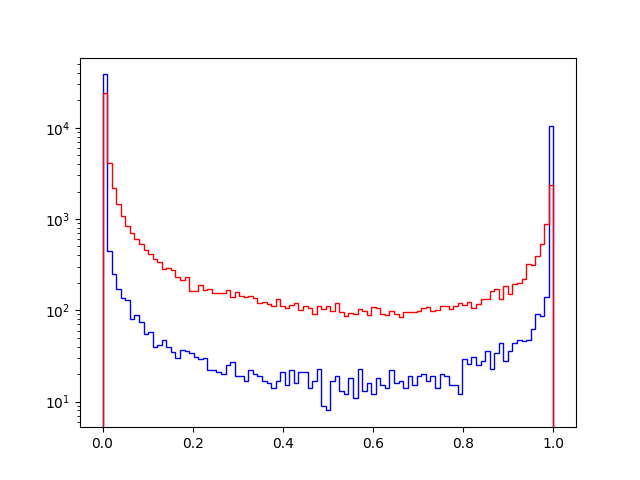

In [31]:
test_extra_labels = a['ParticleNet_extra_label']
test_labels = test_extra_labels>0

print(sum([test_extra_labels[i]==0 for i in range(len(test_extra_labels))]))
ind = 0
while test_extra_labels[ind] == 0:
    ind += 1

print(a['EcalVeto_v12.discValue_'][ind])
print(a['EcalVeto_v12.recoilX_'][ind])


temp = a['ParticleNet_disc']
temp_ = a['EcalVeto_v12.discValue_']
print(temp[:10])
print(temp_[:10])

bins = np.linspace(0, 1.0, 100)

PN = []
EV = []
for i in range(len(temp_)):
    if test_extra_labels[i] == 1:  # 0, or 10, or...
        #print(temp[i])
        PN.append(temp[i])
        EV.append(temp_[i])
        #if temp_[i] > 1.0 - 1e-6 and temp_[i] < 1.0:
        #    print("LESS")
        #    print(temp[i])
        #if temp[i] == 1.0:  print(1)
plt.figure()
plt.hist(PN, bins=bins, histtype='step', color='b')
plt.hist(EV, bins=bins, histtype='step', color='r')
plt.semilogy()
plt.show()

1 MeV


<IPython.core.display.Javascript object>


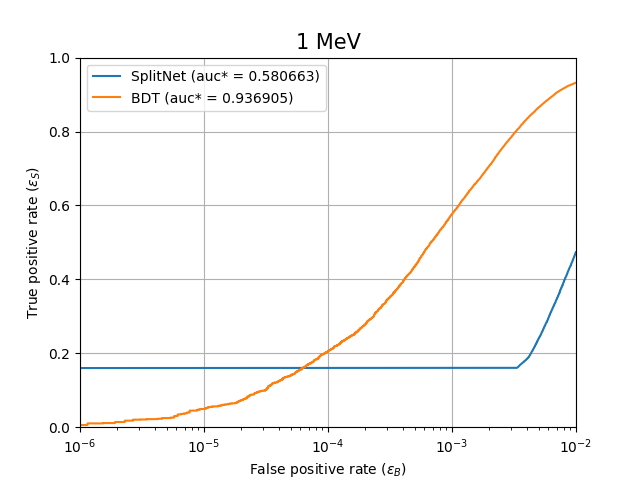

Label:  SplitNet
SplitNet (auc* = 0.580663)
[(0.003341615886355192, 0.16062160092511416, 1.0), (0.003341615886355192, 0.16062160092511416, 1.0), (0.003341615886355192, 0.16062160092511416, 1.0), (0.003341615886355192, 0.16062160092511416, 1.0)]
Label:  BDT
BDT (auc* = 0.936905)
[(0.0010002611114617594, 0.576106240569734, 0.005788386), (0.00010006445001591384, 0.20539800544931516, 0.3625397), (1.0351494829232466e-05, 0.04966339833252098, 0.98606133), (1.1501660921369407e-06, 0.005878819119971619, 0.9995252)]
10 MeV


<IPython.core.display.Javascript object>


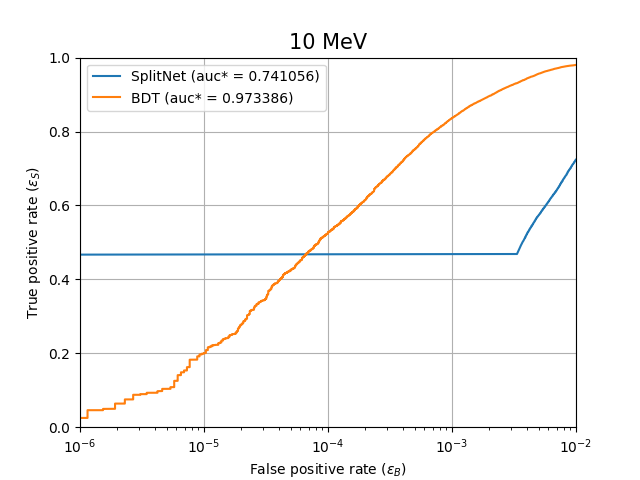

Label:  SplitNet
SplitNet (auc* = 0.741056)
[(0.003341615886355192, 0.4685850287744651, 1.0), (0.003341615886355192, 0.4685850287744651, 1.0), (0.003341615886355192, 0.4685850287744651, 1.0), (0.003341615886355192, 0.4685850287744651, 1.0)]
Label:  BDT
BDT (auc* = 0.973386)
[(0.0010002611114617594, 0.8361734926214893, 0.005788386), (0.00010006445001591384, 0.5258977332518083, 0.3625397), (1.0351494829232466e-05, 0.20062699274475224, 0.98606133), (1.1501660921369407e-06, 0.02507837409309403, 0.9995252)]
100 MeV


<IPython.core.display.Javascript object>


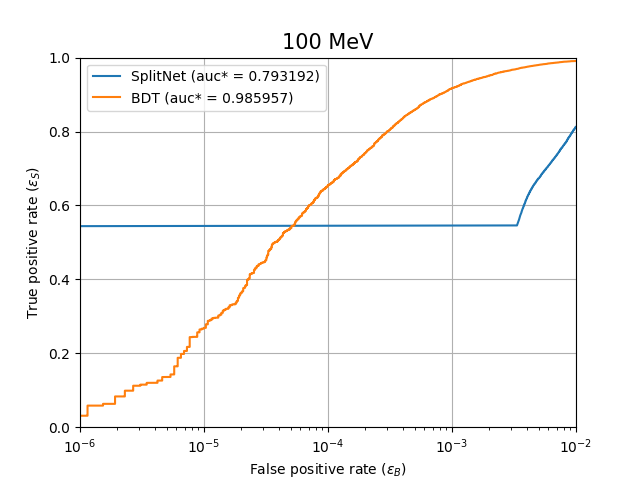

Label:  SplitNet
SplitNet (auc* = 0.793192)
[(0.003341615886355192, 0.5459117950926671, 1.0), (0.003341615886355192, 0.5459117950926671, 1.0), (0.003341615886355192, 0.5459117950926671, 1.0), (0.003341615886355192, 0.5459117950926671, 1.0)]
Label:  BDT
BDT (auc* = 0.985957)
[(0.0010002611114617594, 0.916950995113157, 0.005788386), (0.00010006445001591384, 0.6533930125400902, 0.3625397), (1.0351494829232466e-05, 0.2687922643303293, 0.98606133), (1.1501660921369407e-06, 0.03104880769648858, 0.9995252)]
1000 MeV


<IPython.core.display.Javascript object>


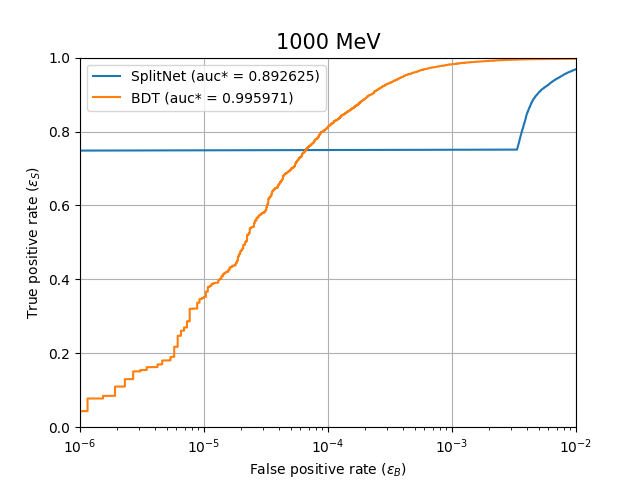

Label:  SplitNet
SplitNet (auc* = 0.892625)
[(0.003341615886355192, 0.7510518618686299, 1.0), (0.003341615886355192, 0.7510518618686299, 1.0), (0.003341615886355192, 0.7510518618686299, 1.0), (0.003341615886355192, 0.7510518618686299, 1.0)]
Label:  BDT
BDT (auc* = 0.995971)
[(0.0010002611114617594, 0.9820698419853254, 0.005788386), (0.00010006445001591384, 0.8120458017178774, 0.3625397), (1.0351494829232466e-05, 0.3525814238850074, 0.98606133), (1.1501660921369407e-06, 0.04341729897578444, 0.9995252)]


In [35]:
roc_info = {}
for k in presel_eff:
    if k > 0:
        mass = '%d MeV' % k
        print(mass)
        roc_info[k] = plotROC([a['ParticleNet_disc'], a['EcalVeto_v12.discValue_']], test_labels, 
                sample_weight=np.logical_or(test_extra_labels == 0, test_extra_labels == k),
                sig_eff=presel_eff[k], bkg_eff=presel_eff[0],
                labels=['SplitNet', 'BDT'], xlim=[1e-6, .01], ylim=[0, 1], logx=True, energy=k)
        #**NOTE:**  The sample_weight line is critical!!  Selects only bkg+sig[k].

In [33]:
roc_info

{1: {'SplitNet': [(0.003341615886355192, 0.16062160092511416, 1.0),
   (0.003341615886355192, 0.16062160092511416, 1.0),
   (0.003341615886355192, 0.16062160092511416, 1.0),
   (0.003341615886355192, 0.16062160092511416, 1.0)],
  'BDT': [(0.0010002611114617594, 0.576106240569734, 0.005788386),
   (0.00010006445001591384, 0.20539800544931516, 0.3625397),
   (1.0351494829232466e-05, 0.04966339833252098, 0.98606133),
   (1.1501660921369407e-06, 0.005878819119971619, 0.9995252)]},
 10: {'SplitNet': [(0.003341615886355192, 0.4685850287744651, 1.0),
   (0.003341615886355192, 0.4685850287744651, 1.0),
   (0.003341615886355192, 0.4685850287744651, 1.0),
   (0.003341615886355192, 0.4685850287744651, 1.0)],
  'BDT': [(0.0010002611114617594, 0.8361734926214893, 0.005788386),
   (0.00010006445001591384, 0.5258977332518083, 0.3625397),
   (1.0351494829232466e-05, 0.20062699274475224, 0.98606133),
   (1.1501660921369407e-06, 0.02507837409309403, 0.9995252)]},
 100: {'SplitNet': [(0.00334161588635519

In [34]:
plot_bins = {
#     'EcalVetoGabriel_recon.nReadoutHits_':np.linspace(0, 50, 51),
#     'EcalVetoGabriel_recon.deepestLayerHit_':np.linspace(0, 35, 36),
#     'EcalVetoGabriel_recon.summedDet_':np.linspace(0, 2000, 41),
#     'EcalVetoGabriel_recon.summedTightIso_':np.linspace(0, 400, 41),
#     'EcalVetoGabriel_recon.maxCellDep_':np.linspace(0, 400, 41),
#     'EcalVetoGabriel_recon.showerRMS_':np.linspace(0, 250, 26),
#     'EcalVetoGabriel_recon.xStd_':np.linspace(0, 200, 41),
#     'EcalVetoGabriel_recon.yStd_':np.linspace(0, 200, 41),
#     'EcalVetoGabriel_recon.avgLayerHit_':np.linspace(0, 35, 36),
#     'EcalVetoGabriel_recon.stdLayerHit_':np.linspace(0, 20, 21),
#     'EcalVetoGabriel_recon.ecalBackEnergy_':np.linspace(0, 200, 41),
# #     'EcalVetoGabriel_recon.discValue_':np.linspace(0.9, 1, 51),
#     'EcalVetoGabriel_recon.recoilX_':np.linspace(-400, 400, 81),
#     'EcalVetoGabriel_recon.recoilY_':np.linspace(-400, 400, 81),

    'TargetSPRecoilE_pt':np.linspace(-50, 200, 51),

#     'ParticleNet_disc':np.linspace(0, 1, 51),
}

# plot_bins = {
#     'EcalVetoGabriel_recon.ecalLayerEdepReadout_:%d'%i:np.linspace(0, 1000, 51) for i in range(34)
# }


In [17]:
colors = ['#636363', '#74c476', '#3182bd', '#f03b20', '#bd0026']
colors = None

In [18]:
def plot_sig_vs_bkg(var_name):
    if ':' in var_name:
        var, var_idx = var_name.split(':')
        var_idx = int(var_idx)
    else:
        var, var_idx = var_name, None

    arrays = []
    labels = []
    for proc in presel_eff.keys():
        pos = test_extra_labels==proc
        arr = a[var][pos]
        # NEW:  See if direct awkward conversion works
        arr = awkward.to_numpy(arr, allow_missing=True)  #np.array(arr)
        if var_idx:
            arr = arr[:, var_idx]
        if not isinstance(plot_bins[var_name], int):
            arr = np.clip(arr, min(plot_bins[var_name]), max(plot_bins[var_name]))
        arrays.append(arr)
        labels.append('BKG' if proc==0 else '%d MeV'%proc)
    f = plt.figure()
    #TEMP TITLE
    #plt.title("Events without SP hit")
    plt.title("All events")
    #NOTE:  normed=True caused an error; removing it temporarily
    plt.hist(arrays, bins=plot_bins[var_name], label=labels, histtype='step', log=True)
    plt.legend()
    plt.xlabel(var_name)

In [19]:
# plot_sig_vs_bkg('TargetSPRecoilE_pt')

TargetSPRecoilE_pt


<IPython.core.display.Javascript object>


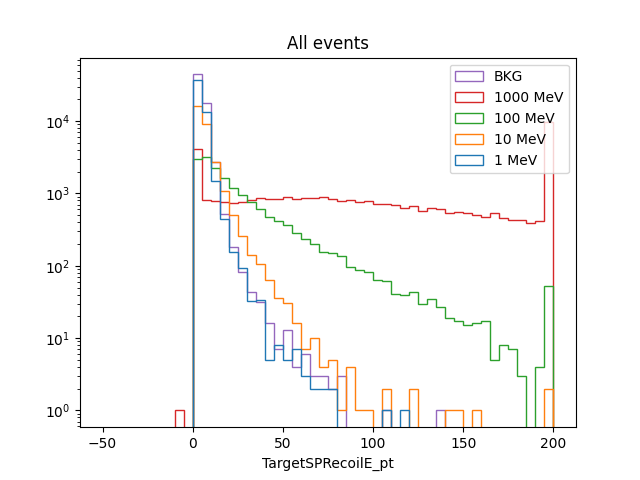

In [20]:
for var in plot_bins:
    print(var)
    plot_sig_vs_bkg(var)

In [21]:
def plot_trend(var_name, proc, eff_levels=None, mistag_levels=[1e-3, 1e-4, 1e-5, 1e-6]):
    if ':' in var_name:
        var, var_idx = var_name.split(':')
        var_idx = int(var_idx)
    else:
        var, var_idx = var_name, None
    if eff_levels is None and mistag_levels is None:
        eff_levels = [1e-3, 1e-4, 1e-5, 1e-6] if proc==0 else [0.9, 0.7, 0.5, 0.2]
    f, axes = plt.subplots(1, 2, figsize=(12, 5))
    f.suptitle('%d MeV'%proc if proc>0 else 'BKG', fontsize=16)
    pos0 = test_extra_labels==proc
    #a_tmp = {k:a[k][pos0] for k in ('ParticleNet_disc', 'EcalVetoGabriel_recon.discValue_', var)}
    # TESTING CONVERSION:
    #a_tmp = {k:np.array(a[k][pos0]) for k in ('ParticleNet_disc', 'EcalVeto_v12.discValue_', var)}
    a_tmp = {k:awkward.to_numpy(a[k][pos0], allow_missing=True) for k in ('ParticleNet_disc', 'EcalVeto_v12.discValue_', var)}
    if var_idx:
        a_tmp[var] = a_tmp[var][:, var_idx]
    # NEW:  Ratio plot testing
    ratio_arrs = []  # PN_disc, ECal.disc
    for i, k in enumerate(['ParticleNet_disc', 'EcalVeto_v12.discValue_']):
        arrs = []
        labels = []
        scores = a_tmp[k]
        if mistag_levels is None:  #NOTE:  Currently modifying this to produce fixed bkg efficiencies...
            #Changing presel_eff[proc] to 1 (Warning:  bkg will be messed up)
            pcts = (1 - np.array(eff_levels)/presel_eff[1]) * 100.
            print('effs=', pcts)
            thresholds = [-99] + list(np.percentile(scores, pcts))
        else:
            thresholds = [-99] + [info[-1] for info in roc_info[1]['SplitNet' if i==0 else 'BDT']]
        print(k, thresholds)
        for idx, thres in enumerate(thresholds):
            pos = scores>thres
#             print(k, thres, pos.sum())
            if not isinstance(plot_bins[var_name], int):
                arrs.append(np.clip(a_tmp[var][pos], min(plot_bins[var_name]), max(plot_bins[var_name])))
            else:
                arrs.append(a_tmp[var][pos])
            if mistag_levels is None:
                labels.append('inclusive' if idx==0 else ('$\epsilon_{B}$=%.0e'%eff_levels[idx-1] if proc==0 else '$\epsilon_{S}$=%.1f'%eff_levels[idx-1]))
            else:
                labels.append('inclusive' if idx==0 else '$\epsilon_{B}$=%.0e'%mistag_levels[idx-1])

        axes[i].hist(arrs, histtype='step', bins=plot_bins[var_name], density=True, log=True, label=labels, color=colors, linewidth=2)
        axes[i].set_title('ParticleNet' if i==0 else 'BDT')  #, '+str(proc if proc>0 else 'BKG')+' MeV
        axes[i].set_xlabel(var)
        axes[i].set_ylim(1e-6, 30)
        axes[i].legend(loc='best')
        
        ratio_arrs.append(arrs)
    """print(len(ratio_arrs))
    print(len(ratio_arrs[0]))
    print(len(ratio_arrs[0][0]))
    plot_histos_PN = [np.histogram(a, plot_bins[var_name]) for a in ratio_arrs[0]]
    plot_histos_EV = [np.histogram(a, plot_bins[var_name]) for a in ratio_arrs[1]]
    print(len(plot_histos_PN), len(plot_histos_PN[0]))
    print(plot_bins[var_name])
    print(np.histogram(ratio_arrs[0], bins=plot_bins[var_name]))
    plot_histo_ratios = [[a / b for a, b in zip(ah, bh)] for ah, bh in zip(plot_histos_PN, plot_histos_EV)]
    plt_bins_ = [plot_bins[var_name][p] for p in range(len(plot_bins[var_name]-1))]
    plot_bins_ = [plt_bins_ for i in range(len(plot_histos_PN))]
    plt.figure(figsize=(6, 3))
    plt.title('Ratio of PN pT / BDT pT')
    plt.plot(plot_bins_, plot_histo_ratios, label=labels)
    plt.legend(loc='best')
    plt.show()"""

TargetSPRecoilE_pt


<IPython.core.display.Javascript object>


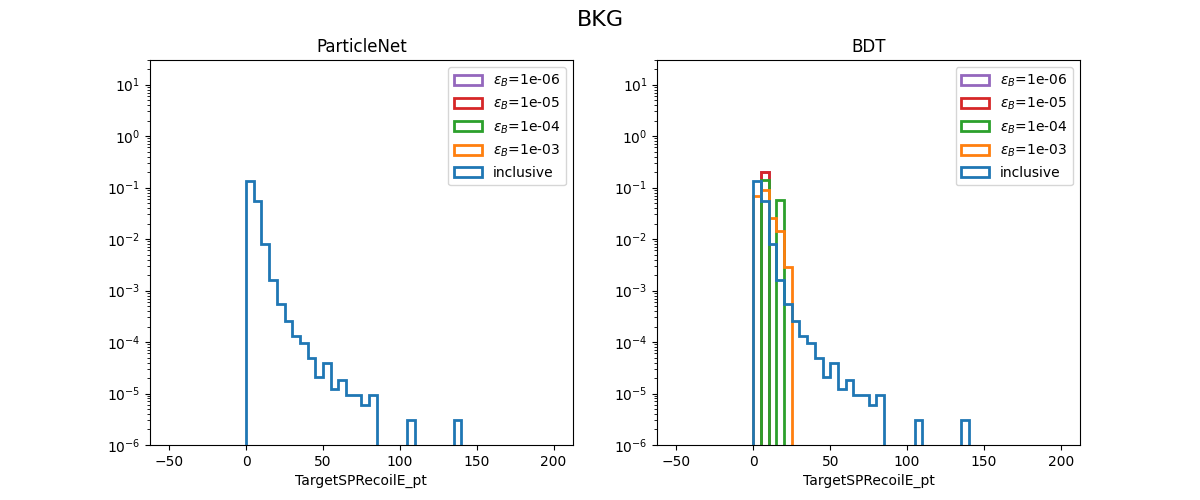

effs= [99.89432432 99.98943243 99.99894324 99.99989432]
ParticleNet_disc [-99, 1.0, 1.0, 1.0, 1.0]
effs= [99.89432432 99.98943243 99.99894324 99.99989432]
EcalVeto_v12.discValue_ [-99, 0.9191875131382763, 0.9973979823641652, 0.9996493788150663, 0.9998005184688965]


/home/pmasterson/miniconda3/envs/pytorch/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


<IPython.core.display.Javascript object>


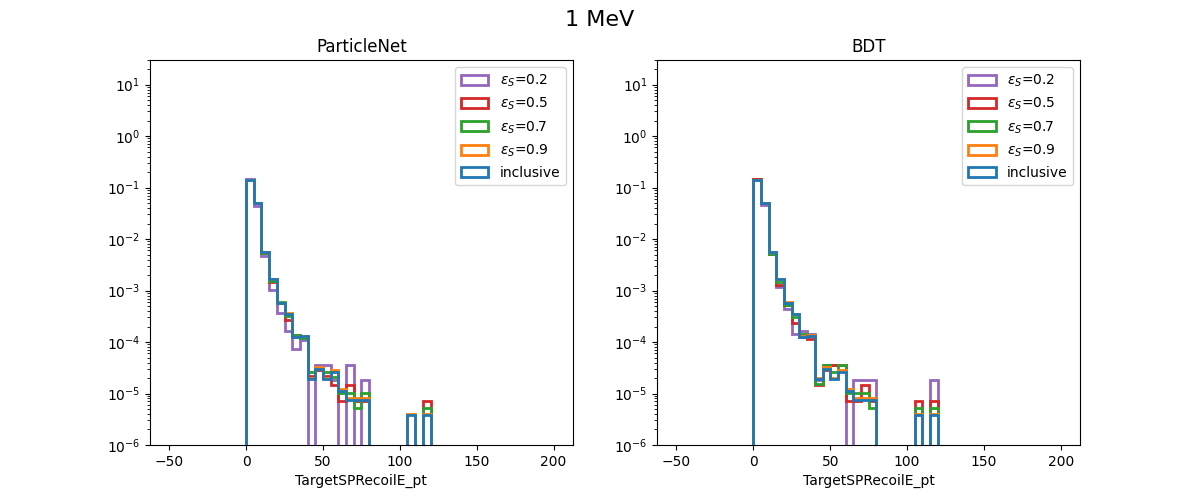

effs= [ 4.89188718 26.02702336 47.16215955 78.86486382]
ParticleNet_disc [-99, 2.3811946606937013e-15, 3.2596352111442414e-12, 5.439044972293117e-09, 0.8426326986601542]
effs= [ 4.89188718 26.02702336 47.16215955 78.86486382]
EcalVeto_v12.discValue_ [-99, 0.00024813042647165806, 0.0019051933575180502, 0.011553145337158796, 0.3878371166556175]


<IPython.core.display.Javascript object>


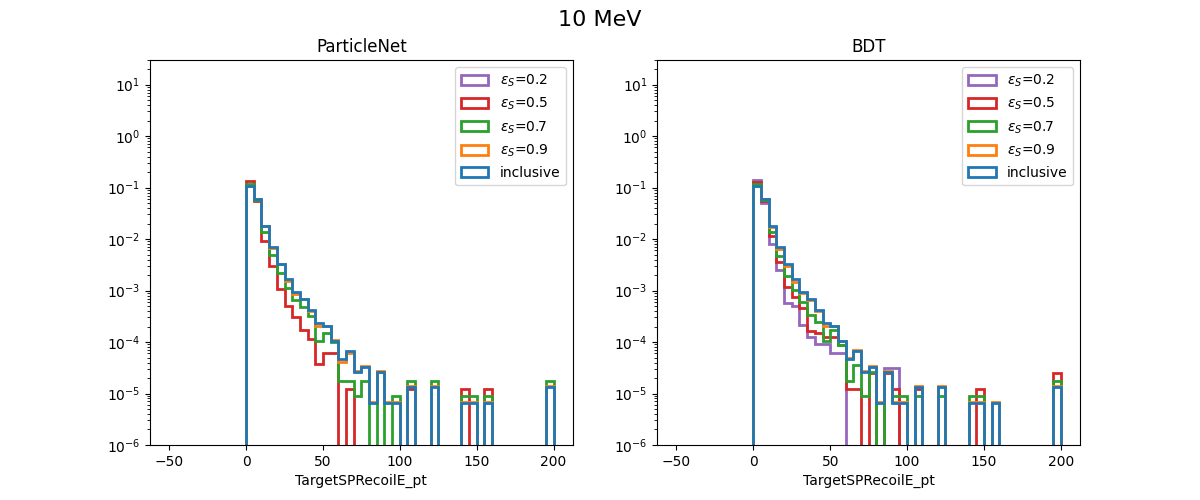

/home/pmasterson/miniconda3/envs/pytorch/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


effs= [ 4.89188718 26.02702336 47.16215955 78.86486382]
ParticleNet_disc [-99, 3.706556475934367e-14, 1.1891170580571471e-08, 0.9951261519819222, 1.0]
effs= [ 4.89188718 26.02702336 47.16215955 78.86486382]
EcalVeto_v12.discValue_ [-99, 0.0006432391777116843, 0.02931337564276183, 0.37670464498690426, 0.9845627584097687]


<IPython.core.display.Javascript object>


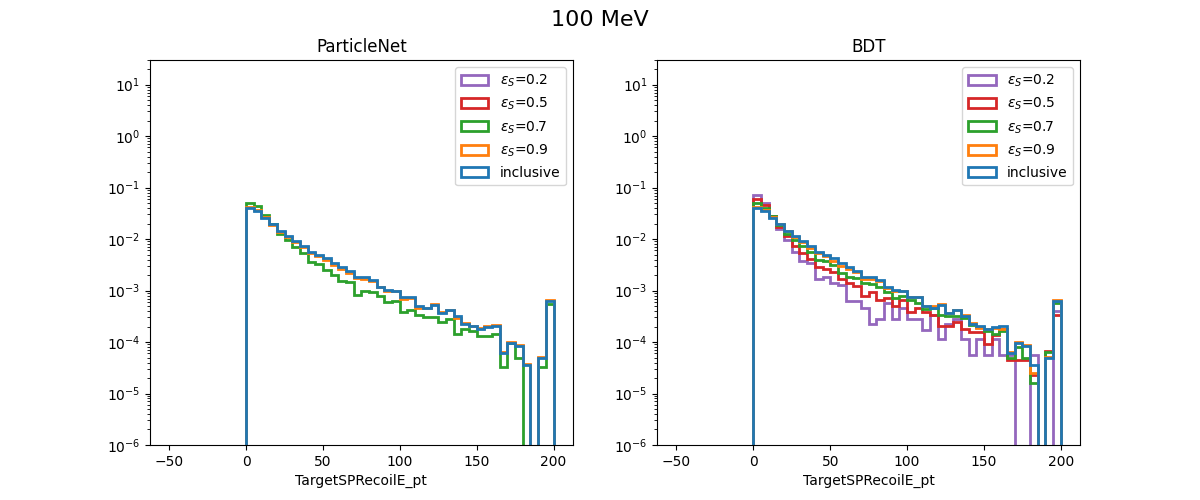

effs= [ 4.89188718 26.02702336 47.16215955 78.86486382]
ParticleNet_disc [-99, 5.195511713802251e-13, 2.4638026727705752e-05, 1.0, 1.0]
effs= [ 4.89188718 26.02702336 47.16215955 78.86486382]
EcalVeto_v12.discValue_ [-99, 0.0023050265871192425, 0.14610315656391537, 0.7595633555654889, 0.9916214262276831]


/home/pmasterson/miniconda3/envs/pytorch/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


<IPython.core.display.Javascript object>


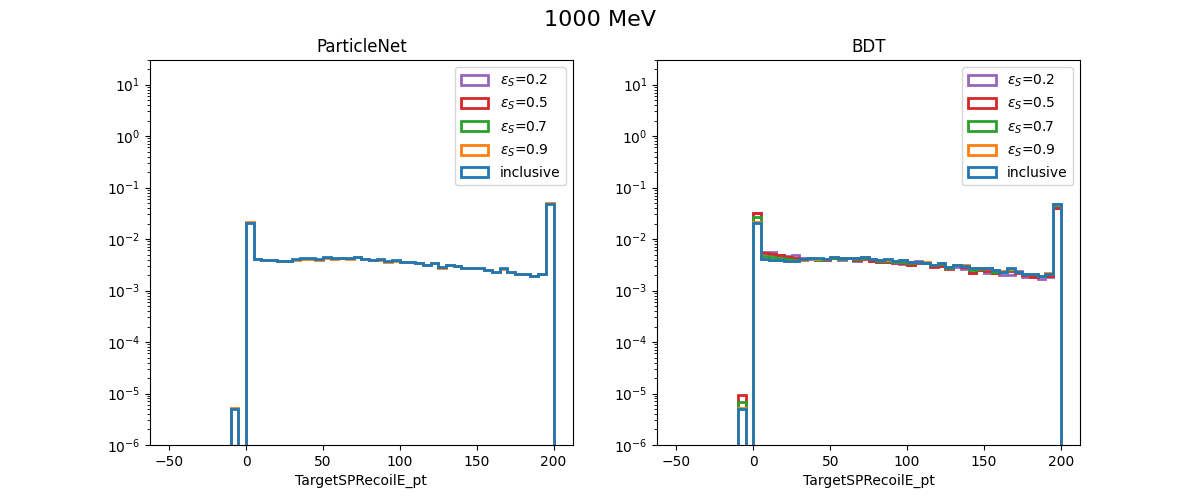

effs= [ 4.89188718 26.02702336 47.16215955 78.86486382]
ParticleNet_disc [-99, 5.325093811325254e-06, 1.0, 1.0, 1.0]
effs= [ 4.89188718 26.02702336 47.16215955 78.86486382]
EcalVeto_v12.discValue_ [-99, 0.03320601373560718, 0.610654108759792, 0.9434061304241591, 0.9948573320150427]


/home/pmasterson/miniconda3/envs/pytorch/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


In [22]:
# compare shapes with succesively tighter selections
# keep BKG mistag rate the same for all signal points

for var in plot_bins:
    print(var)
    plot_trend(var, proc=0, mistag_levels=None)
    plot_trend(var, proc=1, mistag_levels=None)
    plot_trend(var, proc=10, mistag_levels=None)
    plot_trend(var, proc=100, mistag_levels=None)
    plot_trend(var, proc=1000, mistag_levels=None)

TargetSPRecoilE_pt


<IPython.core.display.Javascript object>


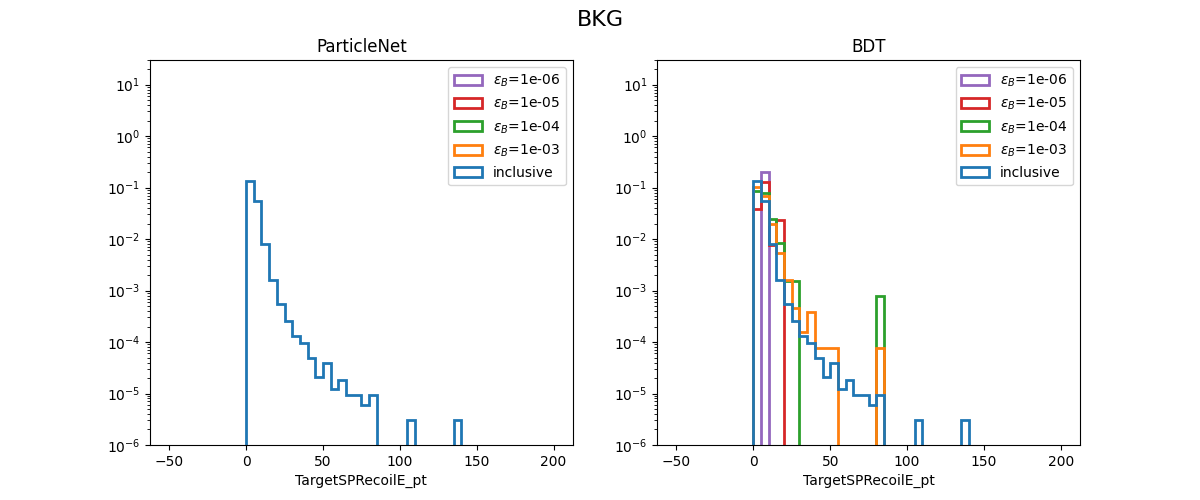

ParticleNet_disc [-99, 1.0, 1.0, 1.0, 1.0]


/home/pmasterson/miniconda3/envs/pytorch/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


EcalVeto_v12.discValue_ [-99, 0.005788386, 0.3625397, 0.98606133, 0.9995252]


<IPython.core.display.Javascript object>


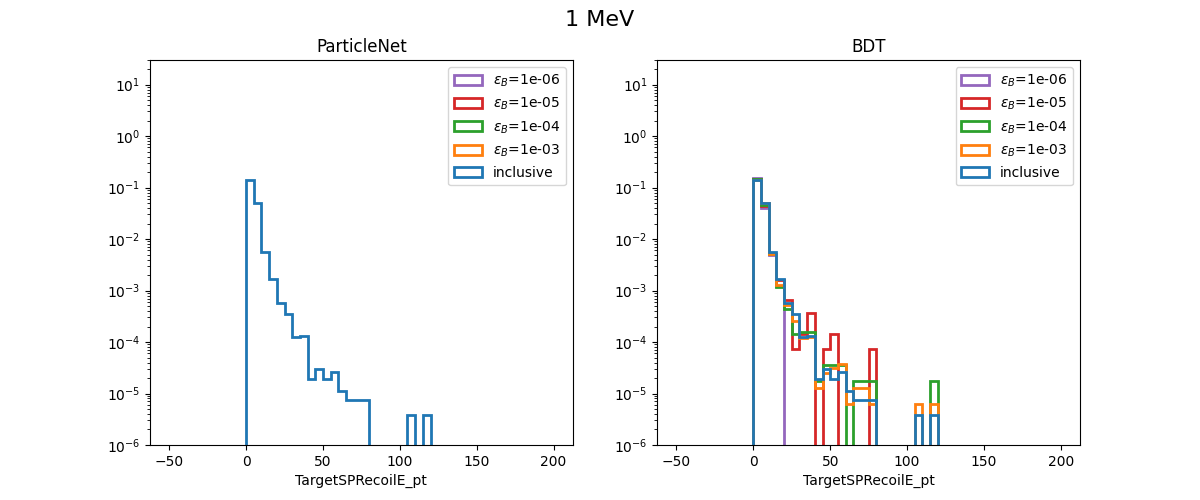

ParticleNet_disc [-99, 1.0, 1.0, 1.0, 1.0]
EcalVeto_v12.discValue_ [-99, 0.005788386, 0.3625397, 0.98606133, 0.9995252]


/home/pmasterson/miniconda3/envs/pytorch/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


<IPython.core.display.Javascript object>


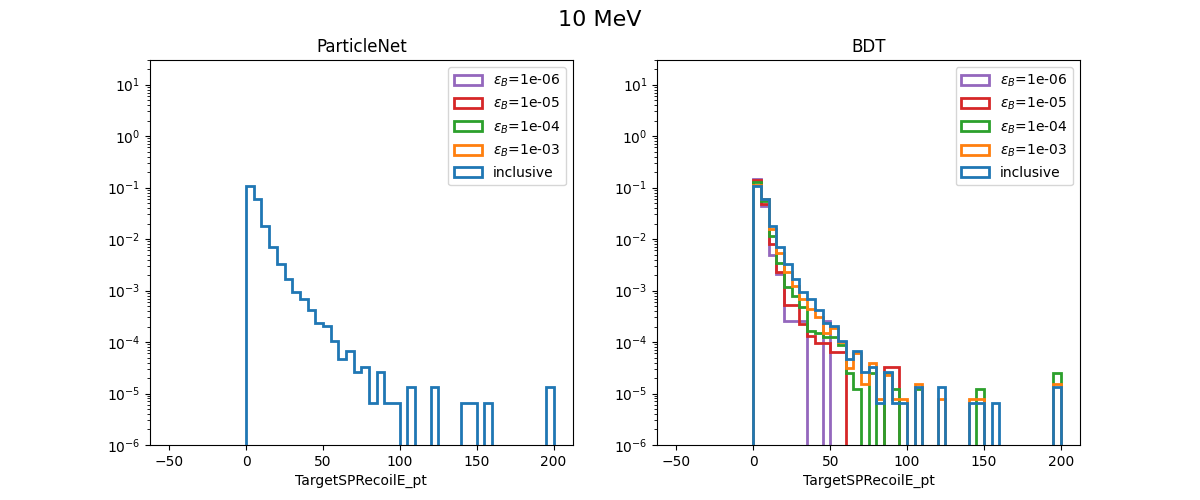

ParticleNet_disc [-99, 1.0, 1.0, 1.0, 1.0]
EcalVeto_v12.discValue_ [-99, 0.005788386, 0.3625397, 0.98606133, 0.9995252]


/home/pmasterson/miniconda3/envs/pytorch/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


<IPython.core.display.Javascript object>


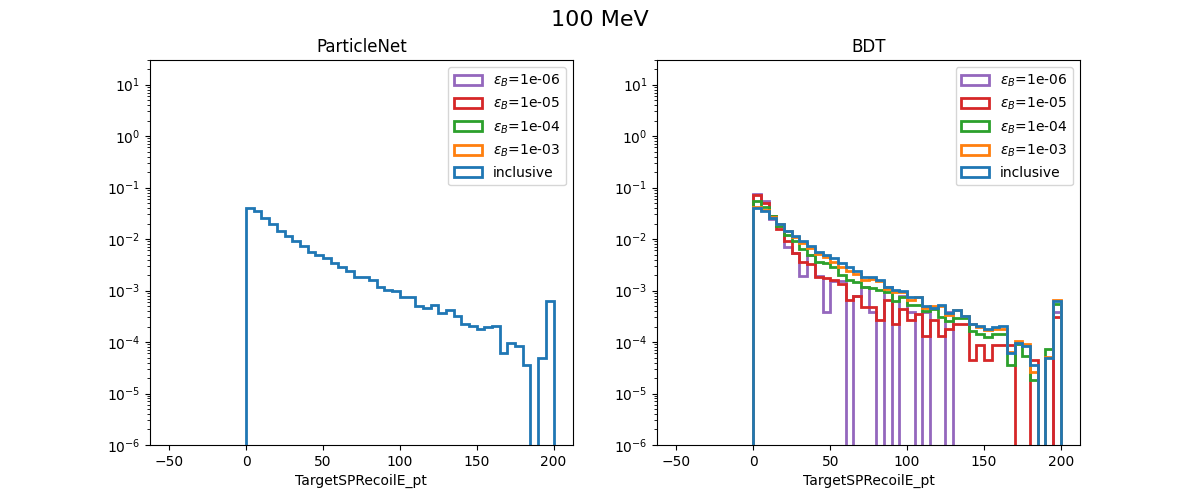

ParticleNet_disc [-99, 1.0, 1.0, 1.0, 1.0]


/home/pmasterson/miniconda3/envs/pytorch/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


EcalVeto_v12.discValue_ [-99, 0.005788386, 0.3625397, 0.98606133, 0.9995252]


<IPython.core.display.Javascript object>


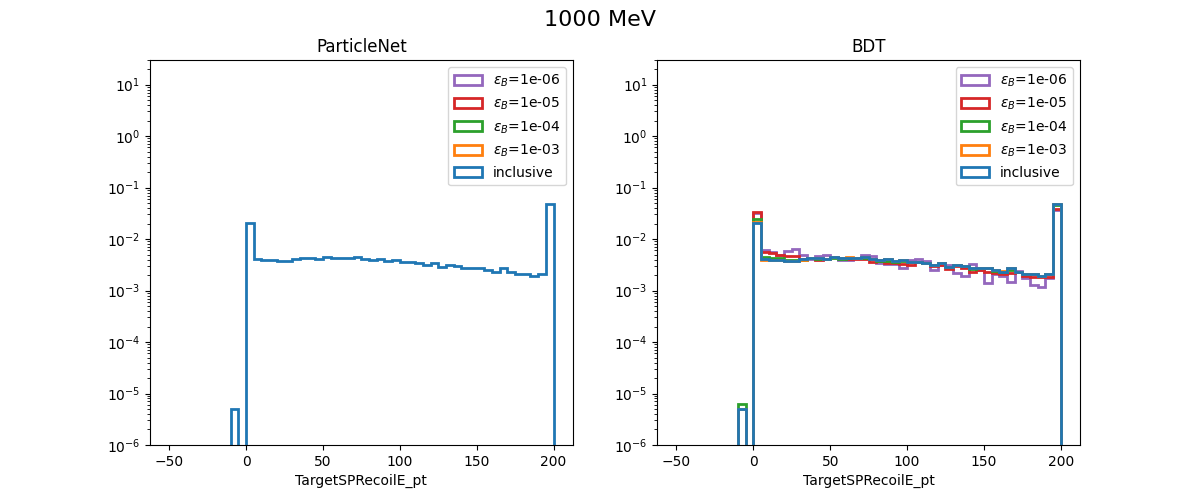

ParticleNet_disc [-99, 1.0, 1.0, 1.0, 1.0]
EcalVeto_v12.discValue_ [-99, 0.005788386, 0.3625397, 0.98606133, 0.9995252]


/home/pmasterson/miniconda3/envs/pytorch/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


In [23]:
# compare shapes with succesively tighter selections
# keep SIG efficiency the same for all signal points

for var in plot_bins:
    print(var)
    plot_trend(var, proc=0)
    plot_trend(var, proc=1)
    plot_trend(var, proc=10)
    plot_trend(var, proc=100)
    plot_trend(var, proc=1000)
    
# All:  pT bias still visible in 10MeV
# SP hit:  pT bias mostly gone
# No SP hit:  no pT bias, as usual

In [24]:
# NEW RATIO PLOTS:
# Plot the above histogram results, except as fractions:  bin height / incl bin height for each efficiency.
colors_new = ['tab:purple', 'tab:red', 'tab:green', 'tab:orange']

def plot_trend_ratio(var_name, proc, eff_levels=None, mistag_levels=[1e-3, 1e-4, 1e-5, 1e-6]):
    if ':' in var_name:
        var, var_idx = var_name.split(':')
        var_idx = int(var_idx)
    else:
        var, var_idx = var_name, None
    if eff_levels is None and mistag_levels is None:
        eff_levels = [1e-3, 1e-4, 1e-5, 1e-6] if proc==0 else [0.9, 0.7, 0.5, 0.2]
    f, axes = plt.subplots(1, 2, figsize=(12, 2))
    #f.suptitle('%d MeV'%proc if proc>0 else 'BKG', fontsize=16)
    pos0 = test_extra_labels==proc
    #a_tmp = {k:a[k][pos0] for k in ('ParticleNet_disc', 'EcalVetoGabriel_recon.discValue_', var)}
    # TESTING CONVERSION:
    a_tmp = {k:np.array(a[k][pos0]) for k in ('ParticleNet_disc', 'EcalVeto_v12.discValue_', var)}
    if var_idx:
        a_tmp[var] = a_tmp[var][:, var_idx]
    # NEW:  Ratio plot testing
    ratio_arrs = []  # PN_disc, ECal.disc
    for i, k in enumerate(['ParticleNet_disc', 'EcalVeto_v12.discValue_']):
        arrs = []
        labels = []
        scores = a_tmp[k]
        if mistag_levels is None:  #NOTE:  Currently modifying this to produce fixed bkg efficiencies...
            #Changing presel_eff[proc] to 1 (Warning:  bkg will be messed up)
            pcts = (1 - np.array(eff_levels)/presel_eff[1]) * 100.
            print('effs=', pcts)
            thresholds = [-99] + list(np.percentile(scores, pcts))
        else:
            thresholds = [-99] + [info[-1] for info in roc_info[1]['SplitNet' if i==0 else 'BDT']]
        print(k, thresholds)
        # NEW:  Ratio plot
        for idx, thres in enumerate(thresholds):
            pos = scores>thres
#             print(k, thres, pos.sum())
            if not isinstance(plot_bins[var_name], int):
                arrs.append(np.clip(a_tmp[var][pos], min(plot_bins[var_name]), max(plot_bins[var_name])))
            else:
                arrs.append(a_tmp[var][pos])
            if mistag_levels is None:
                labels.append('inclusive' if idx==0 else ('$\epsilon_{B}$=%.0e'%eff_levels[idx-1] if proc==0 else '$\epsilon_{S}$=%.1f'%eff_levels[idx-1]))
            else:
                labels.append('inclusive' if idx==0 else '$\epsilon_{B}$=%.0e'%mistag_levels[idx-1])
        
        inclusive_index = labels.index('inclusive')
        inclusive_arr = arrs[inclusive_index]
        inclusive_hist,     edges = np.histogram(inclusive_arr, bins=plot_bins[var_name], density=True)
        inclusive_num_hist, edges = np.histogram(inclusive_arr, bins=plot_bins[var_name])
        inclusive_frac_errs = [1/np.sqrt(n) for n in inclusive_num_hist]
        new_labels = []
        ratio_arrs = []
        plt_edges = []
        yerrs = []
        print("inclusive hist shape is", inclusive_hist.shape)
        for l, arr in zip(labels, arrs):
            if l =='inclusive':  continue
            new_hist, edges     = np.histogram(arr, bins=plot_bins[var_name], density=True)
            new_num_hist, edges = np.histogram(arr, bins=plot_bins[var_name])
            bin_errs = [1/np.sqrt(n) for n in new_num_hist]
            ratio_arr = [new_hist[j] / inclusive_hist[j] for j in range(len(new_hist))]  #new_hist / inclusive_hist  # Should perform element-wise division
            frac_errs = [np.sqrt(bin_errs[n]**2 + inclusive_frac_errs[n]**2) for n in range(len(bin_errs))]

            for r in range(len(ratio_arr)):
                if np.isnan(ratio_arr[r]):  ratio_arr[r] = 0
            #print(ratio_arr)
            ratio_arrs.append(ratio_arr)
            yerrs.append(frac_errs)
            plt_edges.append(edges[:-1])
            new_labels.append(l)
        
        # NEW:
        #histo_list = []
        #for arr in arrs:
        #    histo = np.histogram(arr, bins=plot_bins[var_name], density=True)
        #print(plt_edges[0], ratio_arrs[0])
        #print(new_labels, colors[:-1])
        for j in range(len(ratio_arrs)):
            axes[i].errorbar(plt_edges[j], ratio_arrs[j], yerr=yerrs[j], fmt='o', label=new_labels[j], color=colors_new[j], linewidth=2)
        #axes[i].set_title('ParticleNet' if i==0 else 'BDT')  #, '+str(proc if proc>0 else 'BKG')+' MeV
        axes[i].set_xlabel(var)
        axes[i].set_ylabel("events / inclusive")
        axes[i].set_ylim(0, 3)
        axes[i].legend(loc='best')
        

SIG EFFICIENCY PLOTS:
TargetSPRecoilE_pt


<IPython.core.display.Javascript object>


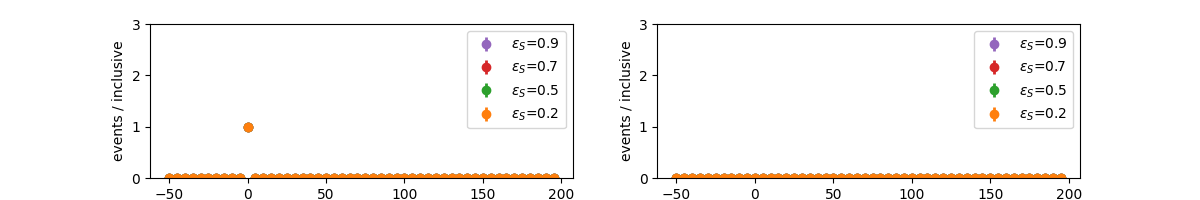

effs= [ 4.89188718 26.02702336 47.16215955 78.86486382]
ParticleNet_disc [-99, 0.7604200112990205, 0.9099024534225464, 0.9511576028357455, 0.9901403789427128]
inclusive hist shape is (50,)
effs= [ 4.89188718 26.02702336 47.16215955 78.86486382]
EcalVeto_v12.discValue_ [-99, 0.0, 0.0, 0.0, 0.0]
inclusive hist shape is (50,)


/home/pmasterson/miniconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in double_scalars
/home/pmasterson/miniconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in double_scalars
/home/pmasterson/miniconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in double_scalars
/home/pmasterson/miniconda3/envs/pytorch/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/pmasterson/miniconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>


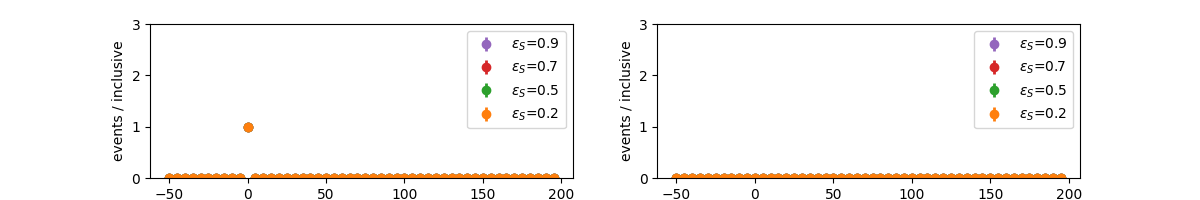

effs= [ 4.89188718 26.02702336 47.16215955 78.86486382]
ParticleNet_disc [-99, 0.8224216396240627, 0.9408875071950951, 0.9734462993229771, 0.996929803865223]
inclusive hist shape is (50,)
effs= [ 4.89188718 26.02702336 47.16215955 78.86486382]
EcalVeto_v12.discValue_ [-99, 0.0, 0.0, 0.0, 0.0]
inclusive hist shape is (50,)


<IPython.core.display.Javascript object>


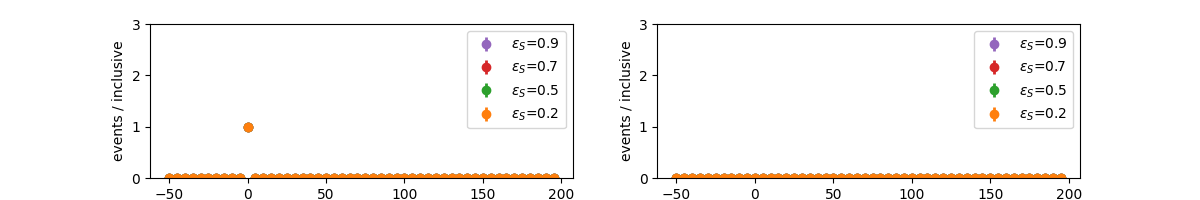

effs= [ 4.89188718 26.02702336 47.16215955 78.86486382]
ParticleNet_disc [-99, 0.8746908594962508, 0.9688361002460664, 0.9900329958991252, 0.9981863933223939]
inclusive hist shape is (50,)
effs= [ 4.89188718 26.02702336 47.16215955 78.86486382]
EcalVeto_v12.discValue_ [-99, 0.0, 0.0, 0.0, 0.0]
inclusive hist shape is (50,)


<IPython.core.display.Javascript object>


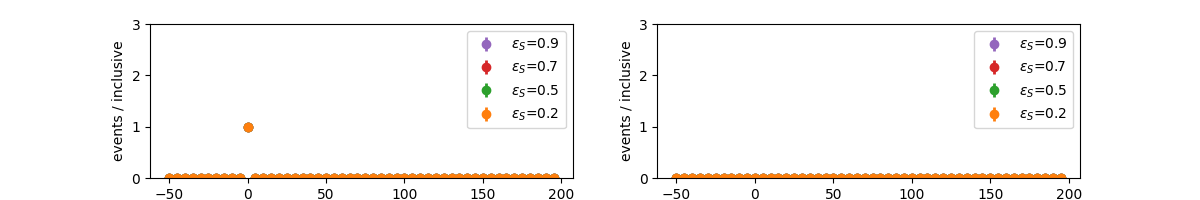

effs= [ 4.89188718 26.02702336 47.16215955 78.86486382]
ParticleNet_disc [-99, 0.9677002591610868, 0.9946895042550618, 0.9975030772149576, 0.999393099815847]
inclusive hist shape is (50,)
effs= [ 4.89188718 26.02702336 47.16215955 78.86486382]
EcalVeto_v12.discValue_ [-99, 0.0, 0.0, 0.0, 0.0]
inclusive hist shape is (50,)
BKG EFFICIENCY PLOTS:
TargetSPRecoilE_pt


<IPython.core.display.Javascript object>


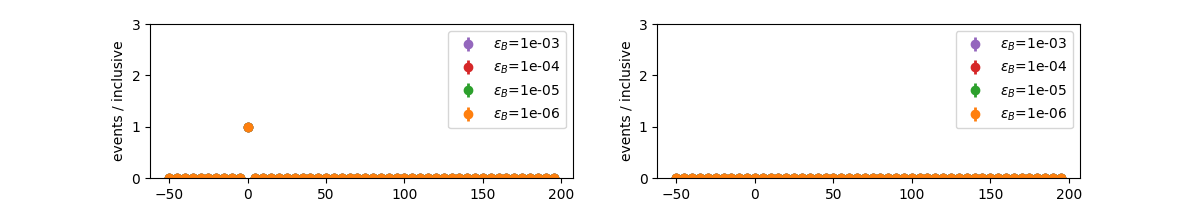

ParticleNet_disc [-99, 0.32889602, 0.81133974, 0.94782716, 0.98240745]
inclusive hist shape is (50,)
EcalVeto_v12.discValue_ [-99, 0.0015890598, 0.010171115, 0.010171115, 0.010171115]
inclusive hist shape is (50,)


/home/pmasterson/miniconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


<IPython.core.display.Javascript object>


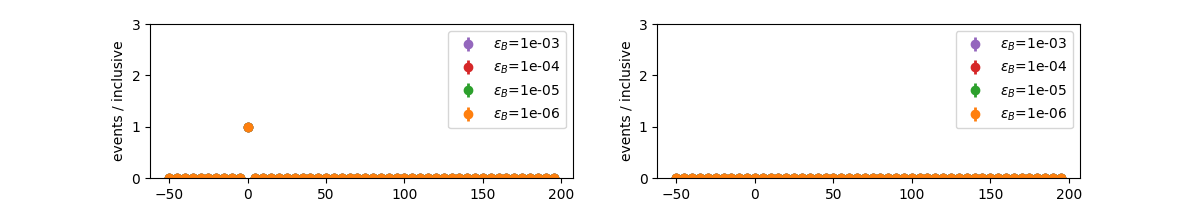

ParticleNet_disc [-99, 0.32889602, 0.81133974, 0.94782716, 0.98240745]
inclusive hist shape is (50,)
EcalVeto_v12.discValue_ [-99, 0.0015890598, 0.010171115, 0.010171115, 0.010171115]
inclusive hist shape is (50,)


<IPython.core.display.Javascript object>


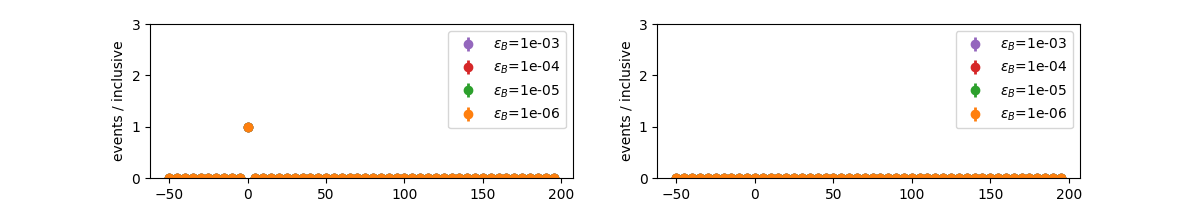

ParticleNet_disc [-99, 0.32889602, 0.81133974, 0.94782716, 0.98240745]
inclusive hist shape is (50,)
EcalVeto_v12.discValue_ [-99, 0.0015890598, 0.010171115, 0.010171115, 0.010171115]
inclusive hist shape is (50,)


<IPython.core.display.Javascript object>


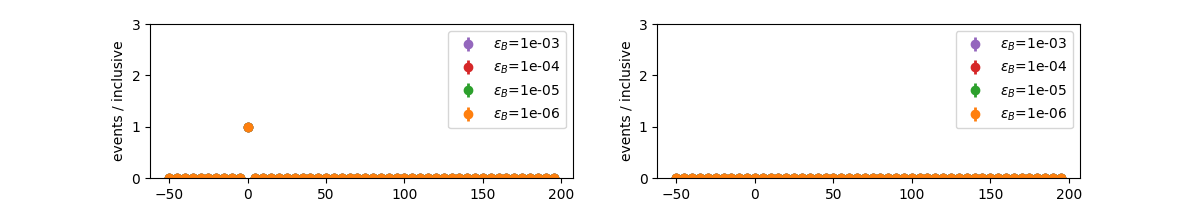

ParticleNet_disc [-99, 0.32889602, 0.81133974, 0.94782716, 0.98240745]
inclusive hist shape is (50,)
EcalVeto_v12.discValue_ [-99, 0.0015890598, 0.010171115, 0.010171115, 0.010171115]
inclusive hist shape is (50,)


In [25]:
print("SIG EFFICIENCY PLOTS:")

for var in plot_bins:
    print(var)
    #plot_trend_ratio(var, proc=0, mistag_levels=None)
    plot_trend_ratio(var, proc=1, mistag_levels=None)
    plot_trend_ratio(var, proc=10, mistag_levels=None)
    plot_trend_ratio(var, proc=100, mistag_levels=None)
    plot_trend_ratio(var, proc=1000, mistag_levels=None)

print("BKG EFFICIENCY PLOTS:")

for var in plot_bins:
    print(var)
    #plot_trend_ratio(var, proc=0)
    plot_trend_ratio(var, proc=1)
    plot_trend_ratio(var, proc=10)
    plot_trend_ratio(var, proc=100)
    plot_trend_ratio(var, proc=1000)

In [29]:
# ***TEMP:***  For looking at distr of high-PN-score events

# Look at semi-ROC curve for BDT, PN...try 1 MeV.
# First, get PN, BDT scores for sig, bkg
#print(set(a['ParticleNet_extra_label']))  # {0.0, 1.0, 100.0, 1000.0, 10.0}
sig_filter = np.array(a['ParticleNet_extra_label'] == 1)
bkg_filter = np.array(a['ParticleNet_extra_label'] == 0)
PN_filter = np.array(a['ParticleNet_disc'] > 0)  # Added--too slow otherwise, only care about high scores
DV_filter = np.array(a['EcalVeto_v12.discValue_'] > 0)
PN_sig = a['ParticleNet_disc'][sig_filter*PN_filter]
PN_bkg = a['ParticleNet_disc'][bkg_filter*PN_filter]
DV_sig = a['EcalVeto_v12.discValue_'][sig_filter*DV_filter]
DV_bkg = a['EcalVeto_v12.discValue_'][bkg_filter*DV_filter]

cuts = 1 - np.logspace(-3, -6, 100)
print("Generating cut arrays:  siglen={}, bkglen={}".format(len(PN_sig), len(PN_bkg)))
print("Generating DV cut arrays:  siglen={}, bkglen={}".format(len(DV_sig), len(DV_bkg)))

PN_sigpass = np.array([sum(PN_sig > c) for c in cuts]) / len(PN_sig)
print("Finished first sig")
PN_bkgpass = np.array([sum(PN_bkg > c) for c in cuts]) / len(PN_bkg)
print("Finished PN")
DV_sigpass = np.array([sum(DV_sig > c) for c in cuts]) / len(DV_sig)
print("Finished DV sig")
DV_bkgpass = np.array([sum(DV_bkg > c) for c in cuts]) / len(DV_bkg)
print("Done")

Generating cut arrays:  siglen=29426, bkglen=77828
Generating DV cut arrays:  siglen=0, bkglen=36848
Finished first sig
Finished PN
Finished DV sig


/home/pmasterson/miniconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


Done


<IPython.core.display.Javascript object>


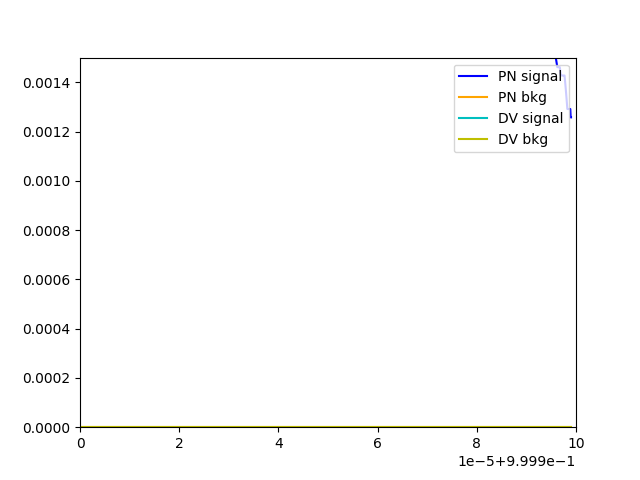

In [30]:
plt.figure()
plt.plot(cuts, PN_sigpass, color='b', label="PN signal")
plt.plot(cuts, PN_bkgpass, color='orange', label="PN bkg")
plt.plot(cuts, DV_sigpass, color='c', label="DV signal")
plt.plot(cuts, DV_bkgpass, color='y', label="DV bkg")
plt.legend(loc=1)
plt.xlim((0.9999, 1))
plt.ylim((0, 0.0015))
plt.show()

In [29]:
bins = np.linspace(0.999, 1, 50)
#plt.figure()
#plt.hist(PN_sig, bins=bins, histtype='step')
#plt.hist(PN_bkg, bins=bins, histtype='step')
#plt.show()
print("Starting")
for p in range(len(PN_bkg)):
    if PN_bkg[p] > 0.999:  print(PN_bkg[p], DV_bkg[p])
print("Completed")
# For PN double:  6 1.0s, 3-4 @ min precision

Starting
Completed
